## Séance 4 : Introduction to Computer Vision with Python
### Auteur : Nennouche Mohamed
### Contenu du notebook :
On va au cours de cette séance découvrir le Computer Vision avec Python, principalement en utilisant OpenCV. Dans ce notebook on passera par toutes les étapes classiques d'un problème de classification en Computer Vision : 
- Préparation du dataset
- Prétraitement des images
- Extraction de caractéristiques
- Classification des images
- Evaluation du modèle

Pour se faire on va utiliser une partie du dataset GTSRB pour la classification de différents types de plaques de signalisation routière

In [1]:
import cv2 as cv
import numpy as np
import seaborn as sns 
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt
import utils

from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

## Phase de prétraitement

### Lecture de toutes les images

In [2]:
images_avertissement = utils.load_images_from_folder("./Traffic-routier/Avertissement")
images_interdiction = utils.load_images_from_folder("./Traffic-routier/Interdiction_restriction")
images_obligation = utils.load_images_from_folder("./Traffic-routier/Obligation")

### Application d'un filtre médian

In [3]:
for i in range(len(images_avertissement)) :
    images_avertissement[i] = cv.medianBlur(images_avertissement[i],3)
    images_interdiction[i] = cv.medianBlur(images_interdiction[i],3)
    images_obligation[i] = cv.medianBlur(images_obligation[i],3)

### On réalise une conversion de l’espace RGB vers l’espace Y’CbCr

![Conversion Y'CbCr](https://d3ltvkh0o2kr33.cloudfront.net/help/yuv-420-ycbcr-422-rgb-444-cest-quoi-le-chroma-subsampling/yuv-ycbcr.jpg)

tels qu'on a : 
$$
𝑌′ =0.299𝑅+0.587𝐺+0.114𝐵 
$$
$$
𝐶_𝑏 =−0.1687𝑅−0.3313𝐺+0.5𝐵+128 
$$
$$
𝐶_𝑟  =0.5𝑅−0.4187𝐺−0.0813𝐵+128
$$

In [4]:
images_avertissement = utils.conv_RGB_YCbCr(images_avertissement)
images_obligation = utils.conv_RGB_YCbCr(images_obligation)
images_interdiction = utils.conv_RGB_YCbCr(images_interdiction)

### Redimensionnement des images en 64x128 pixels

In [5]:
images_avertissement = utils.image_resizer(images_avertissement)
images_obligation = utils.image_resizer(images_obligation)
images_interdiction = utils.image_resizer(images_interdiction)

In [6]:
images_avertissement[3].shape

(128, 64, 3)

## Calcul du HoG

In [7]:
fv_avertissement,hog_image_avertissement = utils.hog_list(images_avertissement)
fv_obligation,hog_image_obligation = utils.hog_list(images_obligation)
fv_interdiction,hog_image_interdiction = utils.hog_list(images_interdiction)

Exemple d'une image HoG

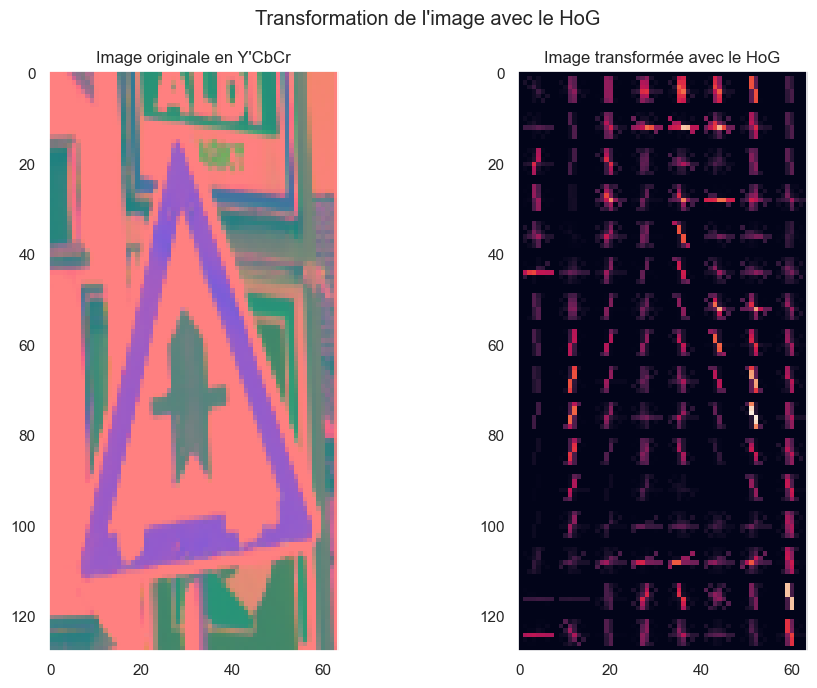

In [10]:
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.grid(False)
plt.imshow(images_avertissement[0])
plt.title("Image originale en Y'CbCr")
plt.subplot(1,2,2)
plt.grid(False)
plt.imshow(hog_image_avertissement[0])
plt.title("Image transformée avec le HoG")
plt.suptitle("Transformation de l'image avec le HoG")
plt.tight_layout()
plt.show()

## Préparation des données pour le modèle

In [11]:
fv_train, fv_test, labels_train, labels_test = utils.prep_data(
    listfeatures=[fv_avertissement, fv_obligation, fv_interdiction],
    test_size= 0.7, 
    random_state= 42
)

In [12]:
print("Le nombre d'échantillon d'entrainement = ",fv_train.shape)
print("Le nombre d'échantillon de test = ",fv_test.shape)

Le nombre d'échantillon d'entrainement =  (45, 3780)
Le nombre d'échantillon de test =  (105, 3780)


## Classification

### KNN

#### Calcul de la distance

- Distance Euclidienne :
$$
    D(a,b) = \sqrt(\sum^n_{i=1}|a_i - b_i|^2)
$$
- Distance Manhattan
$$
    D(a,b) = \sum^n_{i=1}|a_i - b_i|
$$
- Distance Canberra
$$
    D(a,b) = \sum^n_{i=1}\frac{|a_i-b_i|}{|a_i+b_i|}
$$

In [13]:
fv_train.head()

,0,1,2,3,4,5,6,7,8,9,...,3770,3771,3772,3773,3774,3775,3776,3777,3778,3779
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.218337,0.232811,0.030674,0.009964,0.007684,0.036236,0.034874,0.063610,0.243913,0.017449
112,0.392175,0.140068,0.382665,0.123899,0.083074,0.107005,0.081169,0.069892,0.386412,0.392175,...,0.081263,0.277841,0.028715,0.006012,0.005139,0.017618,0.000000,0.007583,0.353427,0.353427
100,0.303586,0.185415,0.029396,0.000000,0.157810,0.000000,0.015315,0.103015,0.164301,0.247512,...,0.314110,0.314110,0.000000,0.000000,0.049385,0.046566,0.102111,0.096311,0.314110,0.314110
2,0.048966,0.013012,0.024071,0.007404,0.014548,0.004337,0.010973,0.028716,0.012011,0.068424,...,0.060487,0.293280,0.074039,0.045012,0.019403,0.103125,0.046107,0.094264,0.054810,0.293280
63,0.355311,0.108157,0.015556,0.004348,0.045375,0.000000,0.000000,0.040939,0.124818,0.486769,...,0.000000,0.059244,0.013945,0.015434,0.000000,0.023386,0.000000,0.011024,0.000000,0.000000


In [14]:
# la mesure de distance est mise par défaut et c'est donc une distance Euclidienne
parameters = {'n_neighbors':np.arange(1,20,1), 'p' : np.arange(1,3,1)}
knn=KNeighborsClassifier()
clf = GridSearchCV(knn, parameters, scoring='accuracy')
clf.fit(fv_train,labels_train)

knn=KNeighborsClassifier(**clf.best_params_)
knn.fit(fv_train,labels_train)

N, train_score, val_score = learning_curve(knn, fv_train, labels_train, train_sizes=np.linspace(0.1, 1.0, 10), cv = 5)

On visualise la courbe d'apprentissage

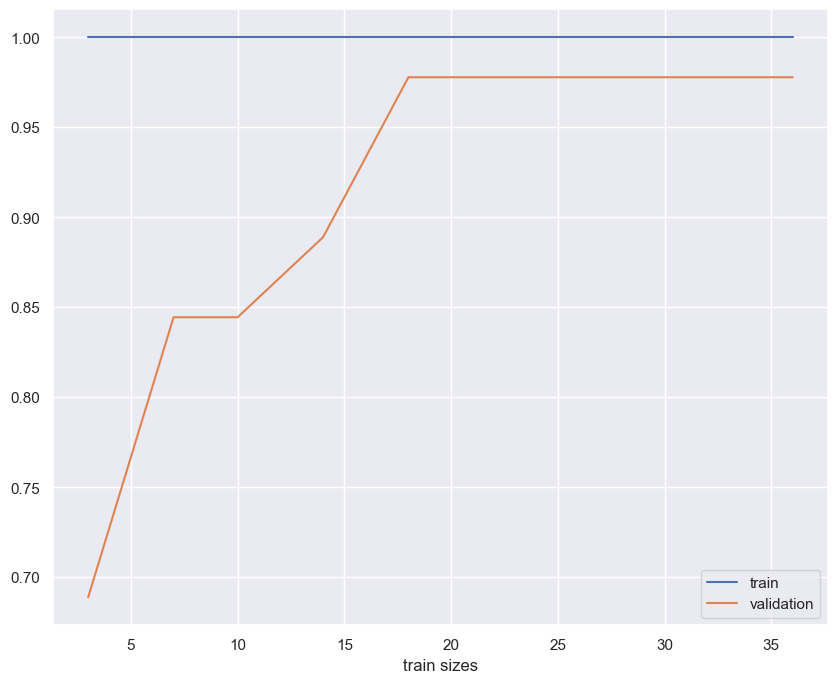

In [15]:
plt.figure(figsize=(10,8))
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train sizes')
plt.legend()

In [16]:
yknn = knn.predict(fv_test)

#### Evaluation du modèle

In [17]:
print("Taux de précision lors de l'entrainement : ",metrics.accuracy_score(labels_train, knn.predict(fv_train)))
print("Taux de précision lors des tests : ",metrics.accuracy_score(labels_test, yknn))

Taux de précision lors de l'entrainement :  1.0
Taux de précision lors des tests :  0.9809523809523809


Text(0.5, 1.0, 'Confusion matrix')

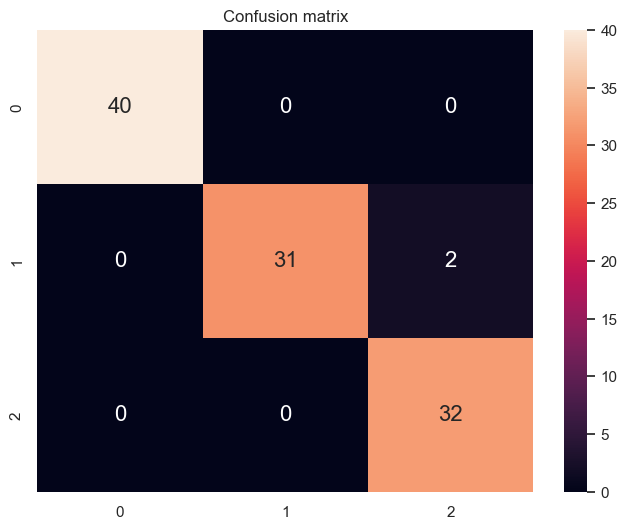

In [18]:
plt.figure(figsize=(8,6))
sns.heatmap(metrics.confusion_matrix(labels_test, yknn), annot=True, annot_kws={"size": 16})
plt.title("Confusion matrix")